In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import spacy
import gensim
import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords



%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

In [2]:
path = os.path.join(os.getcwd(),'recipes')

# Show contents of recipe folder
recipes = os.listdir(path)


# Load in data
list_ = []
for recipe in recipes:
    df = pd.read_json(os.path.join(path,recipe), compression='xz', lines=True, encoding='Latin-1')
    list_.append(df)
    
# Get Column names and shape of each dataset
recipes_ = [x.split('.')[0].replace('-',' ').upper() for x in recipes]
data_cols = {}
for df,name in enumerate(recipes_):
    data_cols[name]=[list_[df].columns.tolist(),list_[df].shape]

In [3]:
# check columns from each dataset for merging
col_df = pd.DataFrame(data_cols)
print(col_df.head())

                                                                                                                                                                              ALLRECIPES RECIPES  \
0  [author, cook_time_minutes, description, error, footnotes, ingredients, instructions, photo_url, prep_time_minutes, rating_stars, review_count, time_scraped, title, total_time_minutes, url]   
1  (225602, 15)                                                                                                                                                                                    

                                                                                                                                                                                                               BBCCOUK RECIPES  \
0  [chef, chef_id, cooking_time_minutes, description, error, ingredients, instructions, instructions_detailed, photo_url, preparation_time_minutes, program, program_id, serves, time_scr

In [4]:
for x in range(4):
    print(recipes_[x])
    print(list_[x].columns.tolist())

ALLRECIPES RECIPES
['author', 'cook_time_minutes', 'description', 'error', 'footnotes', 'ingredients', 'instructions', 'photo_url', 'prep_time_minutes', 'rating_stars', 'review_count', 'time_scraped', 'title', 'total_time_minutes', 'url']
BBCCOUK RECIPES
['chef', 'chef_id', 'cooking_time_minutes', 'description', 'error', 'ingredients', 'instructions', 'instructions_detailed', 'photo_url', 'preparation_time_minutes', 'program', 'program_id', 'serves', 'time_scraped', 'title', 'total_time_minutes', 'url']
COOKSTR RECIPES
['chef', 'comment_count', 'contributors', 'cookbook', 'cookbook_publisher', 'cooking_method', 'copyright', 'cost', 'course', 'date_modified', 'description', 'dietary_considerations', 'difficulty', 'error', 'ingredients', 'ingredients_detailed', 'instructions', 'kid_friendly', 'make_ahead', 'makes', 'meal', 'occasion', 'photo_credit_name', 'photo_credit_site', 'photo_url', 'rating_count', 'rating_value', 'taste_and_texture', 'time_scraped', 'title', 'total_time', 'type_of

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225602 entries, 0 to 225601
Data columns (total 15 columns):
author                225602 non-null object
cook_time_minutes     225602 non-null int64
description           225602 non-null object
error                 225602 non-null bool
footnotes             225602 non-null object
ingredients           225602 non-null object
instructions          225602 non-null object
photo_url             225602 non-null object
prep_time_minutes     225602 non-null int64
rating_stars          225602 non-null float64
review_count          225602 non-null int64
time_scraped          225602 non-null int64
title                 225602 non-null object
total_time_minutes    225602 non-null int64
url                   225602 non-null object
dtypes: bool(1), float64(1), int64(5), object(8)
memory usage: 24.3+ MB
None
['Preheat oven to 400 degrees F (205 degrees C). Butter a 9x9x2 inch baking pan.', 'Melt 1 tablespoon butter in medium nonstick skillet over me

c:\users\corey\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


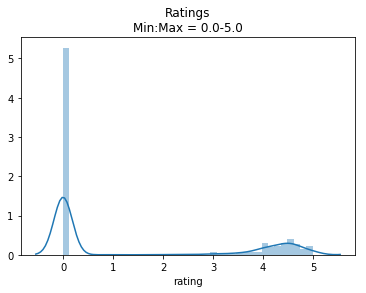

[0.   1.   1.2  1.25 1.29 1.33 1.35 1.4  1.42 1.5  1.55 1.57 1.6  1.63
 1.64 1.67 1.69 1.71 1.73 1.75 1.76 1.8  1.83 1.86 1.88 1.89 1.9  1.91
 1.93 1.95 2.   2.02 2.06 2.07 2.08 2.09 2.11 2.12 2.13 2.14 2.17 2.18
 2.2  2.21 2.22 2.25 2.28 2.29 2.31 2.33 2.34 2.36 2.38 2.39 2.4  2.41
 2.43 2.44 2.45 2.46 2.48 2.49 2.5  2.52 2.53 2.54 2.55 2.56 2.57 2.58
 2.6  2.62 2.63 2.64 2.65 2.67 2.68 2.69 2.7  2.71 2.72 2.73 2.74 2.75
 2.76 2.77 2.78 2.79 2.8  2.81 2.82 2.83 2.84 2.85 2.86 2.87 2.88 2.89
 2.9  2.91 2.92 2.93 2.94 2.95 2.96 2.97 2.98 3.   3.01 3.03 3.04 3.05
 3.06 3.07 3.08 3.09 3.1  3.11 3.12 3.13 3.14 3.15 3.16 3.17 3.18 3.19
 3.2  3.21 3.22 3.23 3.24 3.25 3.26 3.27 3.28 3.29 3.3  3.31 3.32 3.33
 3.34 3.35 3.36 3.37 3.38 3.39 3.4  3.41 3.42 3.43 3.44 3.45 3.46 3.47
 3.48 3.49 3.5  3.51 3.52 3.53 3.54 3.55 3.56 3.57 3.58 3.59 3.6  3.61
 3.62 3.63 3.64 3.65 3.66 3.67 3.68 3.69 3.7  3.71 3.72 3.73 3.74 3.75
 3.76 3.77 3.78 3.79 3.8  3.81 3.82 3.83 3.84 3.85 3.86 3.87 3.88 3.89
 3.9  

In [5]:
# Allrecipes check
allrecipes = list_[0]
#print(allrecipes.head())
#print(allrecipes.columns.tolist())
#print(allrecipes.describe())
print(allrecipes.info())

# Drop error, author, time_scraped, photo_url
# Error Column is always False, Author is user_name for website, time_scraped and photo_url aren't important
#print(allrecipes.error.unique())
#print(allrecipes.author)

allrecipes = allrecipes.drop(['author', 'error', 'time_scraped', 'photo_url'], 1)

# change name of rating-stars to rating, and drop minutes from time variables
allrecipes.rename({'rating_stars':'rating', 
                   'cook_time_minutes':'cook_time',
                   'prep_time_minutes':'prep_time',
                   'total_time_minutes':'total_time'}, axis=1, inplace=True)
print(allrecipes.instructions[0])
print('-'*50)
print(allrecipes.ingredients[0])
print('-'*50)
print(allrecipes.description[4])
print('-'*50)
print(allrecipes.footnotes[4])
print('-'*50)

# combine the footnote column with the description column
allrecipes.footnotes = allrecipes.footnotes.apply(str)
allrecipes.description = allrecipes.description.str.cat(allrecipes.footnotes, sep=' ')
allrecipes.description = allrecipes.description.str.replace('[','').str.replace(']','')
print(allrecipes.description[4])

# Drop footnote
allrecipes = allrecipes.drop('footnotes',1)

# Check ratings
sns.distplot(allrecipes.rating)
plt.title("Ratings\nMin:Max = "+str(allrecipes.rating.min())+'-'+str(allrecipes.rating.max()))
plt.show()

print(np.sort(allrecipes.rating.unique()))

# Check
print(allrecipes.info())

In [6]:
# BBC CO UK check
bbcrecipes = list_[1]

#print(bbcrecipes.head())
print(bbcrecipes.info())
#print(bbcrecipes.error.unique())

#print(bbcrecipes.instructions_detailed[0])
#print('-'*50)
#print(bbcrecipes.instructions[0])
#print('-'*50)
#print(bbcrecipes.ingredients[0])
#print('-'*50)
print(bbcrecipes.description[10])
print('-'*50)
print(bbcrecipes.program[10])

# Add program to descriptions
bbcrecipes.program = bbcrecipes.program.apply(str)
bbcrecipes.description = bbcrecipes.description.str.cat(bbcrecipes.program, sep=' ')

print(bbcrecipes.description[10])

# Drop error, chef, chef_id, instructions_detailed, photo_url, program, program_id, serves, time_scraped
bbcrecipes = bbcrecipes.drop(['error', 'chef', 'chef_id', 
                              'instructions_detailed', 'photo_url', 
                              'program', 'program_id', 'serves', 'time_scraped'], 1)

bbcrecipes.rename({'cooking_time_minutes':'cook_time',
                   'preparation_time_minutes':'prep_time',
                   'total_time_minutes':'total_time'}, axis=1, inplace=True)
# Check
print(bbcrecipes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10599 entries, 0 to 10598
Data columns (total 17 columns):
chef                        10599 non-null object
chef_id                     10599 non-null object
cooking_time_minutes        10599 non-null int64
description                 10599 non-null object
error                       10599 non-null bool
ingredients                 10599 non-null object
instructions                10599 non-null object
instructions_detailed       10599 non-null object
photo_url                   2225 non-null object
preparation_time_minutes    10599 non-null int64
program                     9626 non-null object
program_id                  9626 non-null object
serves                      10599 non-null int64
time_scraped                10599 non-null int64
title                       10599 non-null object
total_time_minutes          10599 non-null int64
url                         10599 non-null object
dtypes: bool(1), int64(5), object(11)
memory usage:

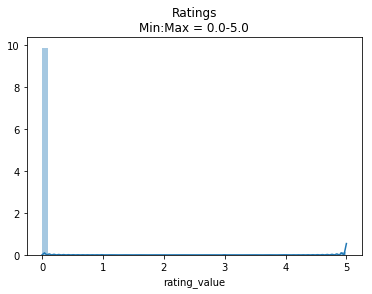

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7918 entries, 0 to 7917
Data columns (total 7 columns):
description     7918 non-null object
ingredients     7918 non-null object
instructions    7918 non-null object
rating          7918 non-null float64
title           7918 non-null object
total_time      7851 non-null object
url             7918 non-null object
dtypes: float64(1), object(6)
memory usage: 433.1+ KB
None


In [7]:
# COOKSTR check
cookstrecipes = list_[2]

#print(cookstrecipes.head())
#print(cookstrecipes.info())
#print(cookstrecipes[cookstrecipes.chef.isnull()]['contributors'])

# lets append the cookbook, publisher cooking_method, cost, course, chef, contributor, dietary_considerations, 
# difficulty, meal, occasion, taste/texture, and type of dish to the description
cols_to_append = ['description', 'chef', 'contributors', 'cookbook', 'cookbook_publisher', 
                  'cooking_method', 'cost', 'course', 'dietary_considerations',
                  'difficulty', 'meal', 'occasion', 'taste_and_texture', 'type_of_dish']

for col in cols_to_append:
    cookstrecipes[col] = cookstrecipes[col].apply(str)
    cookstrecipes.description = cookstrecipes.description.str.cat(cookstrecipes[col], sep=' ')

#print(cookstrecipes.description[4])

# Drop cols to append, comment_count, copyright, date_modified, error, ingredients_detailed, kid_friendly, make_ahead, makes,
# photo stuff, and time scraped
drop_cols = cols_to_append +['rating_count', 'comment_count', 'copyright',
                                  'date_modified','error','ingredients_detailed',
                                  'kid_friendly','make_ahead','makes',
                                  'photo_credit_name','photo_credit_site','photo_url','time_scraped']
# remove description from droplist
drop_cols.pop(0)
#print(drop_cols)
cookstrecipes = cookstrecipes.drop(drop_cols, 1)

#print(cookstrecipes.total_time)

# Check ratings
cookstrecipes.rating_value.fillna(0,inplace=True)
sns.distplot(cookstrecipes.rating_value)
plt.title("Ratings\nMin:Max = "+str(cookstrecipes.rating_value.min())+'-'+str(cookstrecipes.rating_value.max()))
plt.show()

#print(cookstrecipes.rating_value.dropna())

# Rename
cookstrecipes.rename({'rating_value':'rating'}, axis=1, inplace=True)

# Check
print(cookstrecipes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34756 entries, 0 to 34755
Data columns (total 15 columns):
aggregateRating     34756 non-null float64
author              34756 non-null object
dateCrawled         34756 non-null int64
dek                 34756 non-null object
hed                 34756 non-null object
id                  34756 non-null object
ingredients         34656 non-null object
photoData           34756 non-null object
prepSteps           34756 non-null object
pubDate             34756 non-null object
reviewsCount        34756 non-null int64
tag                 34655 non-null object
type                34756 non-null object
url                 34756 non-null object
willMakeAgainPct    34756 non-null int64
dtypes: float64(1), int64(3), object(11)
memory usage: 4.0+ MB
None
How does fried chicken achieve No. 1 status? Brined, boneless thighs are responsible for incredible dark-meat flavor, and the dredge technique creates an insanely crunchy coating.
Pickle-Brined F

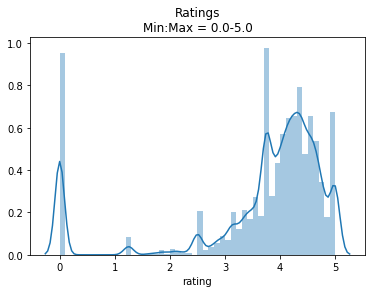

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34569 entries, 0 to 34755
Data columns (total 6 columns):
rating          34569 non-null float64
ingredients     34569 non-null object
instructions    34569 non-null object
review_count    34569 non-null int64
url             34569 non-null object
description     34569 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 1.8+ MB
None


In [8]:
# epicurious check
epicuriousrecipes = list_[3]

#print(cookstrecipes.head())
print(epicuriousrecipes.info())
#print(epicuriousrecipes.author) drop
#print(epicuriousrecipes.id) drop

# Description = dek+hed
# Instructions =prepSteps
print(epicuriousrecipes.dek[0])
print(epicuriousrecipes.hed[0])
epicuriousrecipes['description'] = epicuriousrecipes.dek.str.cat(epicuriousrecipes.hed,sep=' ')
epicuriousrecipes['description'] = epicuriousrecipes.description.str.cat(epicuriousrecipes.tag.apply(str),sep=' ')
print(epicuriousrecipes.description[0])
epicuriousrecipes.rename({'prepSteps':'instructions', 'aggregateRating':'rating', 'reviewsCount':'review_count'}, axis=1, inplace=True)
#print(epicuriousrecipes.type.unique()) drop

# Change rating scale to 0-5
epicuriousrecipes.rating = epicuriousrecipes.rating*(5/4)

# Check ratings
sns.distplot(epicuriousrecipes.rating)
plt.title("Ratings\nMin:Max = "+str(epicuriousrecipes.rating.min())+'-'+str(epicuriousrecipes.rating.max()))
plt.show()


# 100 missing ingredient recipes
#print(epicuriousrecipes[epicuriousrecipes.ingredients.isnull()])

epicuriousrecipes = epicuriousrecipes.dropna(0)

drop_cols = ['author','dateCrawled', 'id', 'dek', 'hed', 'photoData', 'pubDate', 'type', 'willMakeAgainPct', 'tag']
epicuriousrecipes = epicuriousrecipes.drop(drop_cols,1)

print(epicuriousrecipes.info())

In [9]:
# check final dataframes
dfs = [allrecipes, bbcrecipes, cookstrecipes, epicuriousrecipes]
for df in dfs:
    print(df.columns,df.shape[1])
df_all = pd.concat(dfs,0, sort=True)

Index(['cook_time', 'description', 'ingredients', 'instructions', 'prep_time',
       'rating', 'review_count', 'title', 'total_time', 'url'],
      dtype='object') 10
Index(['cook_time', 'description', 'ingredients', 'instructions', 'prep_time',
       'title', 'total_time', 'url'],
      dtype='object') 8
Index(['description', 'ingredients', 'instructions', 'rating', 'title',
       'total_time', 'url'],
      dtype='object') 7
Index(['rating', 'ingredients', 'instructions', 'review_count', 'url',
       'description'],
      dtype='object') 6


In [10]:
print(df_all.head())
print(df_all.shape)
print(df_all.info())

   cook_time  \
0  25.0        
1  0.0         
2  0.0         
3  0.0         
4  45.0        

                                                                                                                                                                                                                                                                description  \
0  I just started adding my favorite things to basic cornbread and I came up with something great!                                                                                                                                                                            
1  These are great as an appetizer or served alongside a meal!                                                                                                                                                                                                                
2  This is the best bread recipe.  Light and fluffy rolls that melt in your mouth. Can be 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278688 entries, 0 to 34755
Data columns (total 10 columns):
cook_time       236201 non-null float64
description     278688 non-null object
ingredients     278688 non-null object
instructions    278688 non-null object
prep_time       236201 non-null float64
rating          268089 non-null float64
review_count    260171 non-null float64
title           244119 non-null object
total_time      244052 non-null object
url             278688 non-null object
dtypes: float64(4), object(6)
memory usage: 23.4+ MB
None


In [11]:
df_all.rating[df_all.rating>0].notnull().sum()

104504

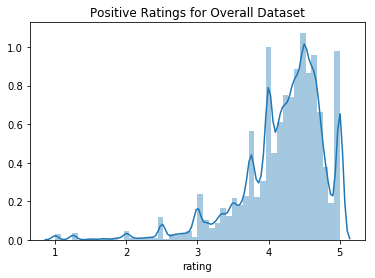

There are 104,504 non-zero ratings in the dataset


In [14]:
sns.distplot(df_all.rating[df_all.rating>0].dropna())
plt.title('Positive Ratings for Overall Dataset')
plt.show()

print("There are {:,d} non-zero ratings in the dataset".format(df_all.rating[df_all.rating>0].notnull().sum()))

[4 3 5 2 1 0]


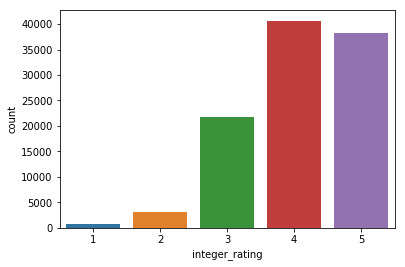

In [31]:
# create 5 categories for ratings
# 1-1.5 =< bin_1
# 1.5 < bin_2 =< 2.5
# 2.5 < bin_3 =< 3.5
# 3.5 < bin_4 < 4.5
# 4.5 < bin_5

df_all['integer_rating'] = pd.Series(0, index=df_all.index)
df_all.loc[(df_all.rating > 0)&(df_all.rating < 2),'integer_rating'] = 1
df_all.loc[(df_all.rating >= 2)&(df_all.rating < 3),'integer_rating'] = 2
df_all.loc[(df_all.rating >= 3)&(df_all.rating < 4),'integer_rating'] = 3
df_all.loc[(df_all.rating >= 4)&(df_all.rating < 4.5),'integer_rating'] = 4
df_all.loc[(df_all.rating >= 4.5),'integer_rating'] = 5

print(df_all.integer_rating.unique())
sns.countplot(df_all.integer_rating[df_all.integer_rating>0])
plt.show()

Want to build model to predict ratings from the 104K that we have to see if the missings can be imputed

In [54]:
print(df_all.shape)
print(df_all.dropna().shape)

(278688, 11)
(225602, 11)


In [56]:
recipe_df = df_all.dropna(1)

print(recipe_df.shape)
#print(recipe_df.head())

# create "corpus" for each recipe
def meta_dump(df):
    return ' '.join(df['ingredients']) + ' ' + ' '.join(df['instructions']) + ' ' + ''.join(df['description'])

recipe_df['corpus'] = recipe_df.apply(meta_dump, axis=1)
print(recipe_df.corpus.head())

(278688, 5)


c:\users\corey\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


0    1/2 cup unsalted butter, chilled and cubed 1 cup chopped onion 1 3/4 cups cornmeal 1 1/4 cups all-purpose flour 1/4 cup white sugar 1 tablespoon baking powder 1 1/2 teaspoons salt 1/2 teaspoon baking soda 1 1/2 cups buttermilk 3 eggs 1 1/2 cups shredded pepperjack cheese 1 1/3 cups frozen corn kernels, thawed and drained 2 ounces roasted marinated red bell peppers, drained and chopped 1/2 cup chopped fresh basil Preheat oven to 400 degrees F (205 degrees C). Butter a 9x9x2 inch baking pan. Melt 1 tablespoon butter in medium nonstick skillet over medium-low heat. Add onion and saute until tender, about 10 minutes. Cool. Mix cornmeal with the flour, baking powder, sugar, salt, and baking soda in large bowl. Add 7 tablespoons butter and rub with fingertips until mixture resembles coarse meal. Whisk buttermilk and eggs in medium bowl to blend. Add buttermilk mixture to dry ingredients and stir until blended. Mix in cheese, corn, red peppers, basil, and onion. Transfer to prepared pan.

Name: corpus, dtype: object


Need to clean text, calculate TFIDF matrix, then find the top key words from each document based on tfidf.

In [ ]:
nlp = spacy.load('en')

############### sample down first ! #############

# Parse the dataset
#doc = recipe_df.corpus.apply(nlp)

In [ ]:
print(doc[0])